Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/dataset/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/dataset/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

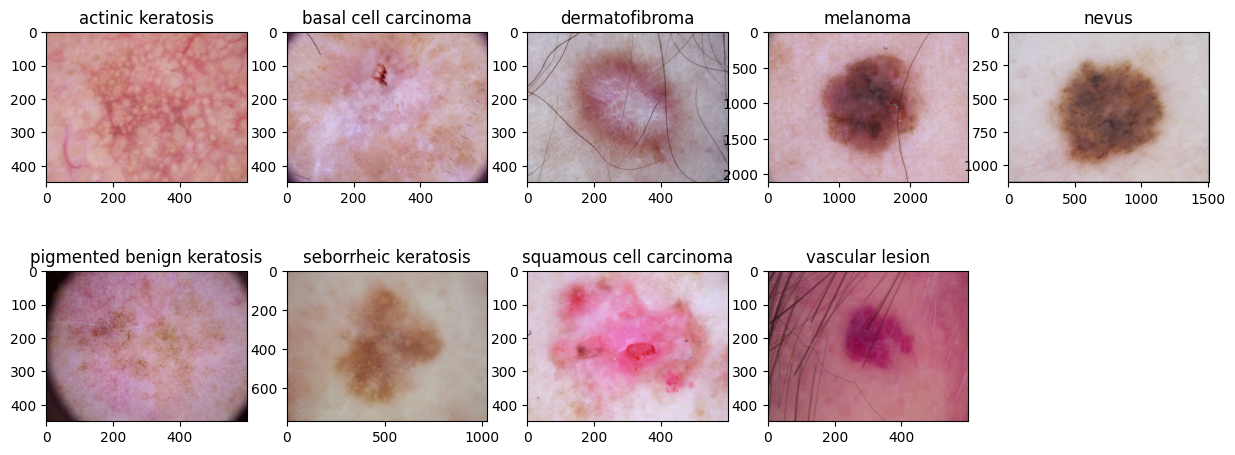

In [14]:
import matplotlib.image as pltimg

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 15))
for i in range(9):
  plt.subplot(5, 5, i + 1)
  image = pltimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 248s 916ms/step - loss: 2.1214 - accuracy: 0.2026 - val_loss: 2.0633 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 79ms/step - loss: 2.0246 - accuracy: 0.2383 - val_loss: 2.0394 - val_accuracy: 0.2103
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.9584 - accuracy: 0.2433 - val_loss: 1.8182 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.9151 - accuracy: 0.2879 - val_loss: 1.8353 - val_accuracy: 0.3535
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7892 - accuracy: 0.3410 - val_loss: 1.6735 - val_accuracy: 0.4340
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 1.7127 - accuracy: 0.3800 - val_loss: 1.8165 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 4s 80ms/step - loss: 1.6733 - accuracy: 0.4079 - val_loss: 1.5722 - val_accuracy: 0.4720
Epoch 8/20
56/56 [===

### Visualizing training results

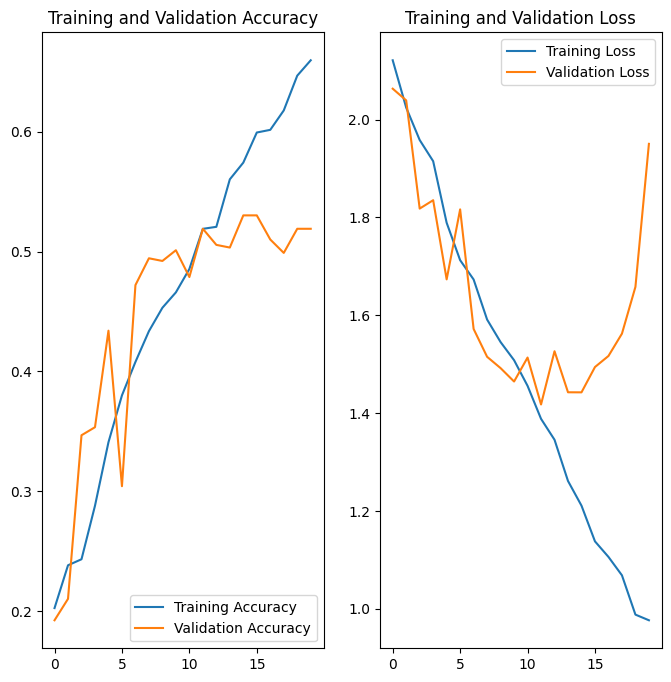

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### findings after the model fit

1. accuracy is around 65% which is very low. possible reasons could be
  1. less epoch, the fit has not learned enough
  1. feature count might be low
1. we can see that there is some overfitting in the model fit towards trianing set as the validation loss is increasing after ~10 epochs

> we should investigate further

### Write your findings here

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1, 0.3), fill_mode='reflect')
])

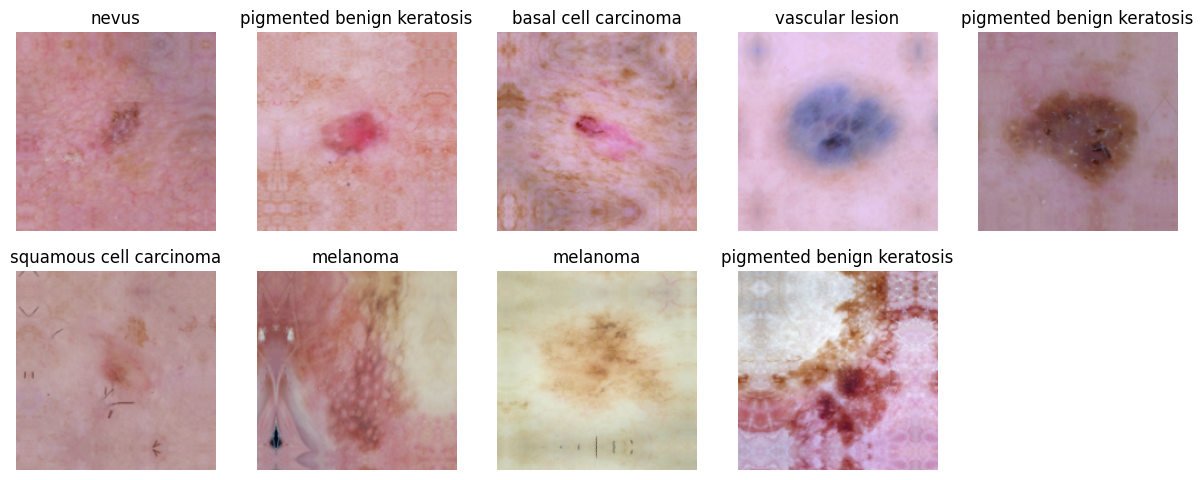

In [28]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([data_aug, layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 8s 92ms/step - loss: 2.0822 - accuracy: 0.1892 - val_loss: 2.0468 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 81ms/step - loss: 2.0463 - accuracy: 0.1964 - val_loss: 1.9763 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 5s 81ms/step - loss: 2.0141 - accuracy: 0.2065 - val_loss: 2.0333 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 85ms/step - loss: 2.0309 - accuracy: 0.2003 - val_loss: 1.9095 - val_accuracy: 0.2841
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0224 - accuracy: 0.2160 - val_loss: 2.0467 - val_accuracy: 0.2327
Epoch 6/20
56/56 [==============================] - 5s 81ms/step - loss: 2.0033 - accuracy: 0.2489 - val_loss: 1.8701 - val_accuracy: 0.3378
Epoch 7/20
56/56 [==============================] - 5s 85ms/step - loss: 1.8476 - accuracy: 0.3231 - val_loss: 1.7473 - val_accuracy: 0.3736
Epoch 8/20
56/56 [======

### Visualizing the results

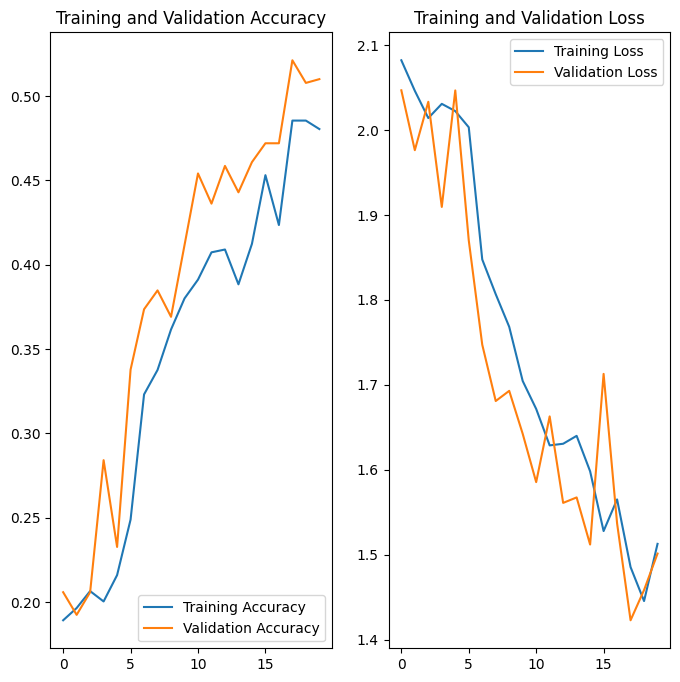

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### findings after the model fit

1. w.r.t. overfitting, yes we can see that training loss and validation loss both have very similar graphs here. we can surely say that overfitting is resolved for now
1. but on the other hand the general accuracy of the model fit has decreased to `48%`, which is very bad for the model.
> although if we compare to the validation accuracy of the fit earlier, the fit is still at the same accuracy. that could be a importance observation.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

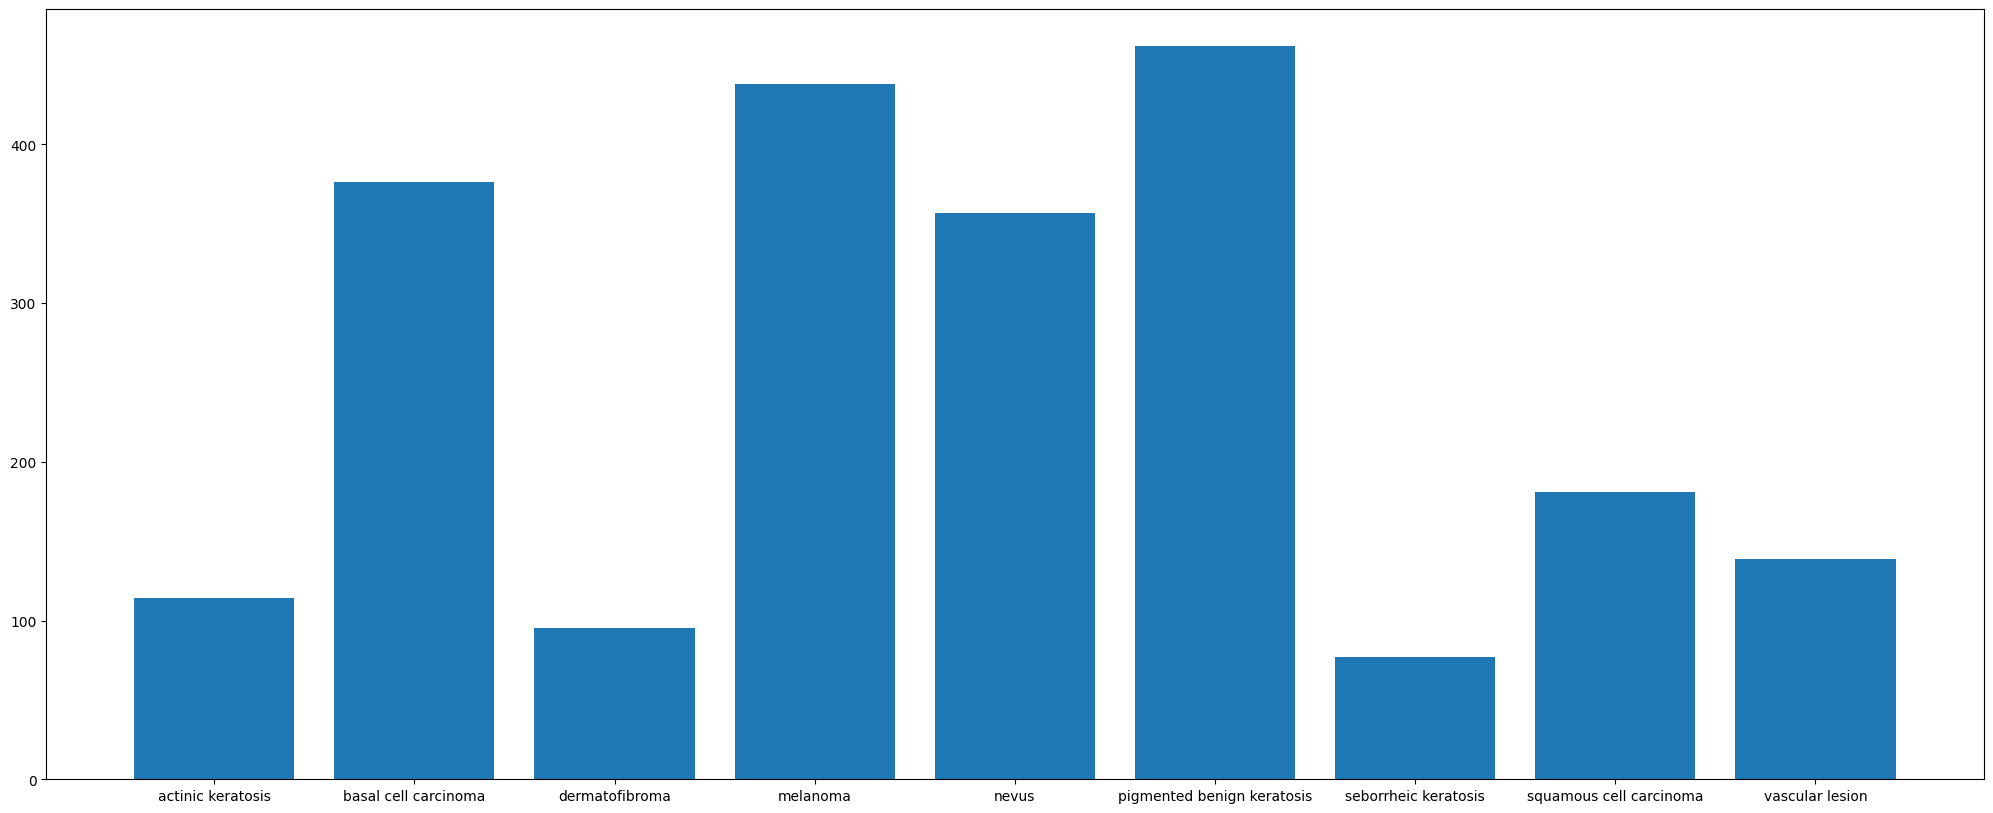

In [41]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
- `Seborrheic keratosis`

#### - Which classes dominate the data in terms proportionate number of samples?
- `Pigmented Benign keratosis`





#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
path_to_training_dataset="/content/gdrive/MyDrive/dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A7BD112D240>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7B54119570>: 100%|██████████| 500/500 [00:26<00:00, 18.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7C0D4CB370>: 100%|██████████| 500/500 [00:17<00:00, 27.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7A7C0D4CB2E0>: 100%|██████████| 500/500 [01:31<00:00,  5.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7A7B54311B10>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7B543B8C40>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A7B5454F940>: 100%|██████████| 500/500 [00:41<00:00, 12.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7B54571450>: 100%|██████████| 500/500 [00:18<00:00, 26.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A7B543B8CA0>: 100%|██████████| 500/500 [00:17<00:00, 28.14 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [49]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0026693.jpg_5bc91fa3-a814-4a33-b9a5-eb69d99a6e13.jpg',
 '/content/gdrive/MyDrive/dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0033349.jpg_527f86a7-8835-40a4-b168-937365f236a7.jpg',
 '/content/gdrive/MyDrive/dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0028714.jpg_1277bbaa-bd4b-4839-b6f3-8da379f80847.jpg',
 '/content/gdrive/MyDrive/dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0026068.jpg_f3d0fd82-51fc-40ee-80f0-3f0543c3d16c.jpg',
 '/content/gdrive/MyDrive/dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0031065.jpg_01542d32-e744-4dc5-aacc-6e5e0cdc2721.jpg',
 '/content/gdrive/MyDrive/dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0025606.jpg_def07f26-4eeb-4120-b354-80ee2cb2860b.jpg',
 '/content/gdrive/MyDrive/dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0025596.jpg_c341c22

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [50]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [51]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-51-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [52]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [55]:
data_dir_train="/content/gdrive/MyDrive/dataset/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [57]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
num_classes = 9
model = Sequential([data_aug, layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu',input_shape = (180, 180, 32)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [59]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 45s 231ms/step - loss: 2.3122 - accuracy: 0.2135 - val_loss: 27.8608 - val_accuracy: 0.0898
Epoch 2/50
169/169 [==============================] - 49s 282ms/step - loss: 1.9753 - accuracy: 0.2415 - val_loss: 21.0216 - val_accuracy: 0.0898
Epoch 3/50
169/169 [==============================] - 42s 241ms/step - loss: 1.9767 - accuracy: 0.2300 - val_loss: 4.4894 - val_accuracy: 0.1648
Epoch 4/50
169/169 [==============================] - 39s 224ms/step - loss: 1.9425 - accuracy: 0.2494 - val_loss: 2.2080 - val_accuracy: 0.2532
Epoch 5/50
169/169 [==============================] - 44s 253ms/step - loss: 1.9254 - accuracy: 0.2446 - val_loss: 1.8548 - val_accuracy: 0.2814
Epoch 6/50
169/169 [==============================] - 39s 221ms/step - loss: 1.9203 - accuracy: 0.2463 - val_loss: 2.0747 - val_accuracy: 0.2895
Epoch 7/50
169/169 [==============================] - 43s 250ms/step - loss: 1.9112 - accuracy: 0.2587 - val_loss: 2.4276 - val_accuracy: 0

#### **Todo:**  Visualize the model results

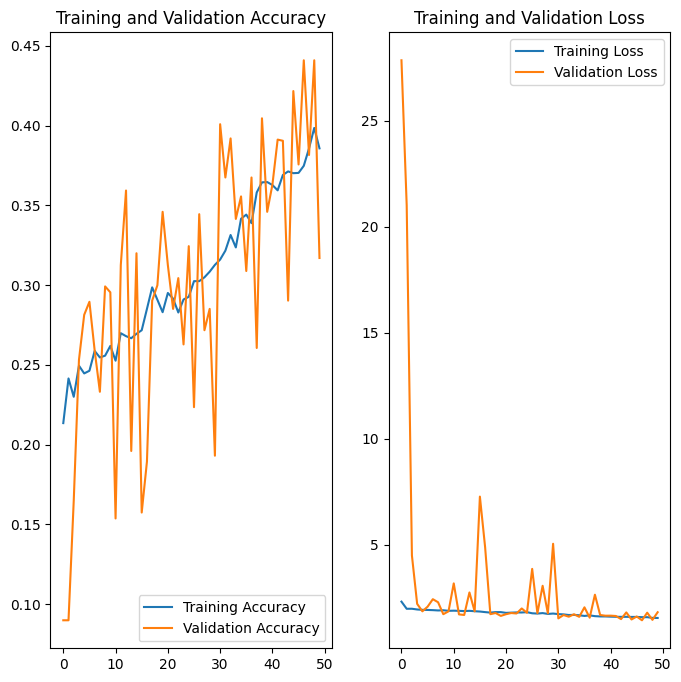

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusions

use of `Augmentor` did increase the corpse, but didn't help our model fit too much.

accuracy has taken a big loss where both training and validation accuracy is around __30 ~ 40%__ range. we surely have handled overfitting. but it is bit unclear if we have introduced underfitting to the model fit due to increased features and variance. the initial validation loss was extremely high, which might be an indicator of underfitting.
